In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d harlfoxem/housesalesprediction 
!unzip housesalesprediction.zip
!rm housesalesprediction.zip

  0% 0.00/780k [00:00<?, ?B/s]
100% 780k/780k [00:00<00:00, 48.0MB/s]
Archive:  housesalesprediction.zip
  inflating: kc_house_data.csv       


In [4]:
data = pd.read_csv('kc_house_data.csv')

In [5]:
print(f'Number of samples = {len(data)}')

Number of samples = 21613


In [6]:
print(f'Number of zipcodes = {len(data.zipcode.unique())}')

Number of zipcodes = 70


In [7]:
data.loc[data.yr_renovated == 0, 'yr_renovated'] = data.yr_built

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=0)

In [10]:
y_val, val_data = val_data['price'], val_data.drop(columns=['price'])

In [11]:
train_data.lat.max() - train_data.lat.min(), train_data.long.max() - train_data.long.min() 

(0.621699999999997, 1.198999999999998)

In [12]:
lat_thresholds = np.linspace(train_data.lat.min(), train_data.lat.max(), num=20)
long_thresholds = np.linspace(train_data.long.min(), train_data.long.max(), num=40)

In [13]:
train_data['zone'] = np.searchsorted(lat_thresholds, train_data['lat']) * len(long_thresholds) + np.searchsorted(long_thresholds, train_data['long'])
val_data['zone'] = np.searchsorted(lat_thresholds, val_data['lat']) * len(long_thresholds) + np.searchsorted(long_thresholds, val_data['long'])

In [14]:
columns_to_drop = ['id', 'date', 'lat', 'long']
train_data = train_data.drop(columns=columns_to_drop)
val_data = val_data.drop(columns=columns_to_drop)

In [15]:
price_by_zone = train_data.groupby(['zone']).price.mean()

In [16]:
price_by_zone = price_by_zone[price_by_zone > 0]

In [17]:
outlier_zones = price_by_zone[(price_by_zone - train_data.price.mean()).abs() > 3 * train_data.price.std()].index

In [18]:
outlier_zones = {zone: i+1 for i, zone in enumerate(outlier_zones)}

In [19]:
outlier_zones

{609: 1, 610: 2, 650: 3}

In [20]:
train_data.zone = train_data.zone.apply(lambda z: outlier_zones.get(z, 0))
val_data.zone = val_data.zone.apply(lambda z: outlier_zones.get(z, 0))

In [21]:
(train_data.zone > 0).sum()

146

In [22]:
y_train, train_data = train_data['price'], train_data.drop(columns=['price'])

In [23]:
train_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,zone
5268,3,1.0,1570,5510,1.0,0,0,4,7,1070,500,1940,1940,98115,1770,6380,0
16909,3,2.5,1780,11000,1.0,0,0,4,8,1210,570,1980,1980,98006,2310,9700,0
16123,3,1.5,1090,9862,1.0,0,0,3,8,1090,0,1987,1987,98074,1710,9862,0
12181,4,2.5,2210,7079,2.0,0,0,3,8,2210,0,1993,1993,98031,1970,7000,0
12617,3,2.5,1800,4763,2.0,0,0,3,7,1240,560,1985,1985,98119,1790,4763,0


In [24]:
train_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'zone'],
      dtype='object')

In [ ]:
categorical_features = ['view', 'zipcode', 'zone']
binary_features = ['waterfront']
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                      'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

In [ ]:
(set(train_data.columns) == set(categorical_features + numerical_features + binary_features),
 len(train_data.columns) == len(categorical_features + numerical_features + binary_features))

(True, True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('std_scaling', StandardScaler(), numerical_features),
    ('passthrough', 'passthrough', binary_features)
])

In [25]:
val_data.to_csv('test_data_example.csv', index=False)

In [26]:
train_data_example = train_data.copy()
val_data_example = val_data.copy()
train_data_example['TARGET'] = y_train
val_data_example['TARGET'] = y_val
data_example = pd.concat((train_data_example, val_data_example))

In [27]:
data_example.to_csv('train_data_example.csv', index=False)

In [ ]:
preprocessed_data.rename(columns={'price': 'target'}).to_csv('preprocessed_data.csv', index=False)

In [ ]:
X_train = transformer.fit_transform(train_data).toarray()
y_train = y_train.to_numpy()

In [ ]:
print(f'Number of features after encoding = {X_train.shape[1]}')

Number of features after encoding = 93


In [ ]:
X_val = transformer.transform(val_data).toarray()
y_val = y_val.to_numpy()

In [ ]:
data = {'X': X_train, 'X_val': X_val, 'y': y_train, 'y_val': y_val}

In [ ]:
def try_params(model_class, data, param_name, param_range, **kwargs):
    hist_list = []
    for p in param_range:
        kwargs[param_name] = p
        model = model_class(**kwargs)
        hist = model.fit(**data)
        hist_list.append(hist)
    return hist_list

In [ ]:
def plot_params(hist_list, param_name, param_range):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for hist, p in zip(hist_list, param_range):
        plt.plot(hist['n_estimators'], hist['val_rmse'], label=f'{param_name} = {p}')
    plt.legend()
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('Val RMSE', fontsize=12)
    plt.xticks(np.linspace(0, hist['n_estimators'][-1], 11))
    plt.grid()
    plt.subplot(1, 2, 2)
    for hist, p in zip(hist_list, param_range):
        plt.plot(hist['n_estimators'], hist['time'], label=f'{param_name} = {p}')
    plt.legend()
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('Time (s)', fontsize=12)
    plt.xticks(np.linspace(0, hist['n_estimators'][-1], 11))
    plt.grid()

In [ ]:
def try_mul_params(model_class, data, param_ranges, **kwargs):
    import itertools
    hist_list = []
    params_list = []
    params_product = list(itertools.product(*param_ranges.values()))
    for i, params in enumerate(params_product):
        params_dict = {name: p for name, p in zip(param_ranges.keys(), params)}
        kwargs.update(params_dict) 
        model = model_class(**kwargs)
        hist = model.fit(**data)
        hist_list.append(hist)
        params_list.append(params_dict)
        print(f'Step {i+1}/{len(params_product)}')
    return params_list, hist_list

In [ ]:
def plot_mul_params(params_list, hist_list):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for hist, params in zip(hist_list, params_list):
        labels = []
        for name, p in params.items():
            if name == 'feature_subsample_size':
                name = 'fss'
            elif name == 'max_depth':
                name = 'md'
            labels.append(f'{name} = {p}')
        plt.plot(hist['n_estimators'], hist['val_rmse'], label=', '.join(labels))
    plt.legend()
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('Val RMSE', fontsize=12)
    plt.xticks(np.linspace(0, hist['n_estimators'][-1], 11))
    plt.grid()
    plt.subplot(1, 2, 2)
    for hist, params in zip(hist_list, params_list):
        labels = []
        for name, p in params.items():
            if name == 'feature_subsample_size':
                name = 'fss'
            elif name == 'max_depth':
                name = 'md'
            labels.append(f'{name} = {p}')
        plt.plot(hist['n_estimators'], hist['time'], label=', '.join(labels))
    plt.legend()
    plt.xlabel('n_estimators', fontsize=12)
    plt.ylabel('Time (s)', fontsize=12)
    plt.xticks(np.linspace(0, hist['n_estimators'][-1], 11))
    plt.grid()

## Случайный лес

In [ ]:
save_path = 'drive/MyDrive/Ensembles/'

In [ ]:
from ensembles import RandomForestMSE
from metrics import rmse

In [ ]:
other_args = {'n_estimators': 50}
fss_rf_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
fss_rf_hist = try_params(RandomForestMSE, data, 'feature_subsample_size', fss_rf_range, **other_args)

Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained


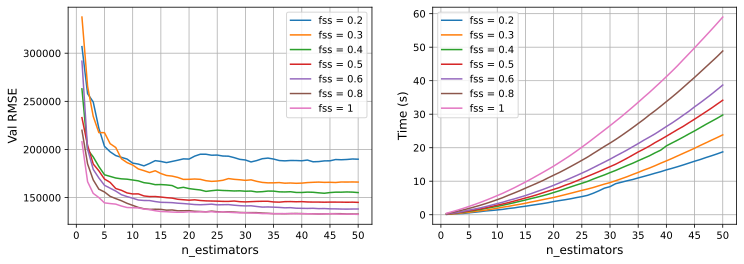

In [ ]:
plot_params(fss_rf_hist, 'fss', fss_rf_range)
plt.savefig(save_path + 'Plots/'+ 'fss_rf.pdf', bbox_inches='tight')
plt.show()

In [ ]:
other_args = {'n_estimators': 50, 'feature_subsample_size': 0.5}
md_rf_range = [5, 7, 10, 15, 25, 50, 75, 100, None]
md_rf_hist = try_params(RandomForestMSE, data, 'max_depth', md_rf_range, **other_args)

Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained
Estimator 50/50 trained


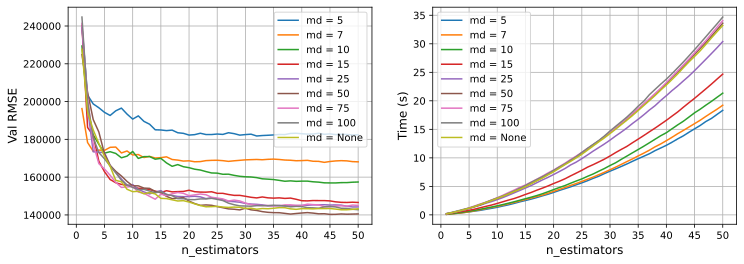

In [ ]:
plot_params(md_rf_hist, 'md', md_rf_range)
plt.savefig(save_path + 'Plots/'+ 'md_rf.pdf', bbox_inches='tight')
plt.show()

In [ ]:
rf_param_ranges = {'max_depth': [15, 50, 75],
                'feature_subsample_size': [0.4, 0.6, 0.8]
                }
rf_mul_params, rf_mul_hist = try_mul_params(RandomForestMSE, data, rf_param_ranges, n_estimators=50)

Estimator 50/50 trained
Step 1/9
Estimator 50/50 trained
Step 2/9
Estimator 50/50 trained
Step 3/9
Estimator 50/50 trained
Step 4/9
Estimator 50/50 trained
Step 5/9
Estimator 50/50 trained
Step 6/9
Estimator 50/50 trained
Step 7/9
Estimator 50/50 trained
Step 8/9
Estimator 50/50 trained
Step 9/9


In [ ]:
import pickle as pkl

In [ ]:
save_path = 'drive/MyDrive/Ensembles/ExperimentResults/'

In [ ]:
# with open(save_path + 'random_forest_hist_dict', 'wb') as pkl_file:
#     pkl.dump({'params': rf_mul_params, 'hist': rf_mul_hist}, pkl_file)

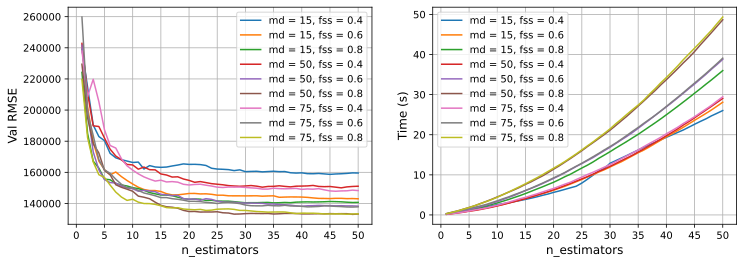

In [ ]:
plot_mul_params(rf_mul_params, rf_mul_hist)
plt.savefig(save_path + 'Plots/'+ 'mul_rf.pdf', bbox_inches='tight')
plt.show()

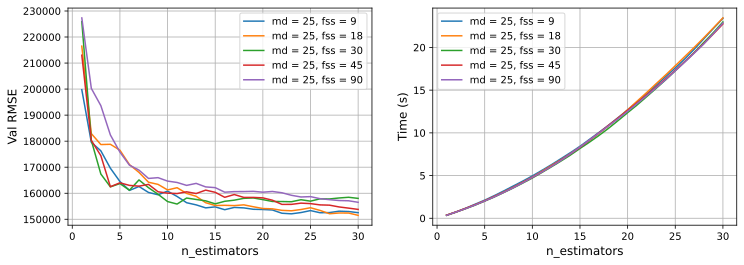

In [ ]:
rf_idxs = [i for i, params in enumerate(rf_mul_params) if params['max_depth'] == 25]
plot_mul_params([rf_mul_params[i] for i in rf_idxs], [rf_mul_hist[i] for i in rf_idxs])

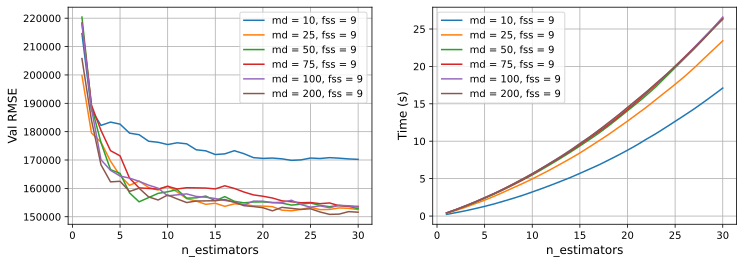

In [ ]:
rf_idxs = [i for i, params in enumerate(rf_mul_params) if params['feature_subsample_size'] == 9]
plot_mul_params([rf_mul_params[i] for i in rf_idxs], [rf_mul_hist[i] for i in rf_idxs])

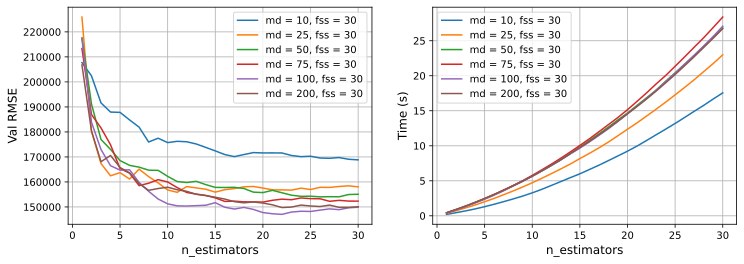

In [ ]:
rf_idxs = [i for i, params in enumerate(rf_mul_params) if params['feature_subsample_size'] == 30]
plot_mul_params([rf_mul_params[i] for i in rf_idxs], [rf_mul_hist[i] for i in rf_idxs])

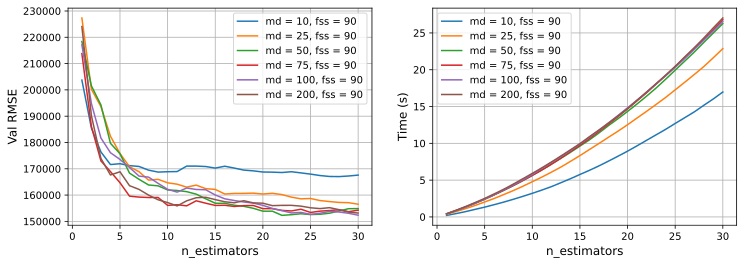

In [ ]:
rf_idxs = [i for i, params in enumerate(rf_mul_params) if params['feature_subsample_size'] == 90]
plot_mul_params([rf_mul_params[i] for i in rf_idxs], [rf_mul_hist[i] for i in rf_idxs])

## Градиентный бустинг

In [ ]:
from ensembles import GradientBoostingMSE

In [ ]:
other_args = {'n_estimators': 100}
md_gb_range = [1, 2, 3, 5, 10, 20, 50, 100, None]
md_gb_hist = try_params(GradientBoostingMSE, data, 'max_depth', md_gb_range, **other_args)

Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained


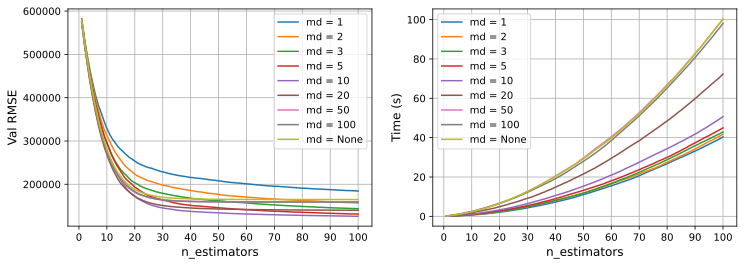

In [ ]:
plot_params(md_gb_hist, 'md', md_gb_range)
plt.savefig(save_path + 'Plots/'+ 'md_gb.pdf', bbox_inches='tight')
plt.show()

In [ ]:
other_args = {'n_estimators': 100}
fss_gb_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
fss_gb_hist = try_params(GradientBoostingMSE, data, 'feature_subsample_size', fss_gb_range, **other_args)

Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained


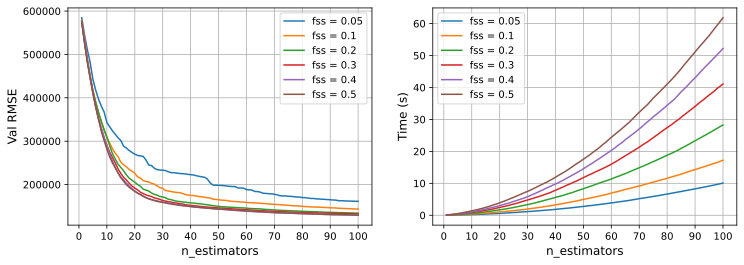

In [ ]:
plot_params(fss_gb_hist, 'fss', fss_gb_range)
plt.savefig(save_path + 'Plots/'+ 'fss_gb.pdf', bbox_inches='tight')
plt.show()

In [ ]:
other_args = {'n_estimators': 100}
lr_gb_range = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
lr_gb_hist = try_params(GradientBoostingMSE, data, 'learning_rate', lr_gb_range, **other_args)

Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained
Estimator 100/100 trained


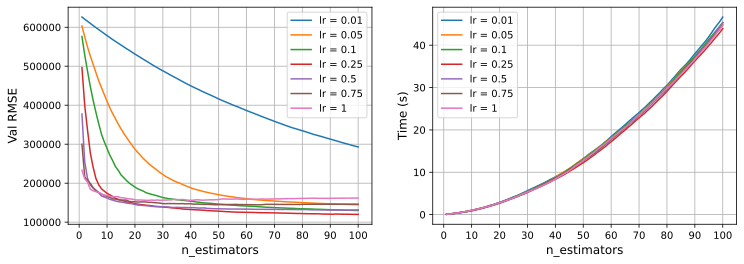

In [ ]:
plot_params(lr_gb_hist, 'lr', lr_gb_range)
plt.savefig(save_path + 'Plots/'+ 'lr_gb.pdf', bbox_inches='tight')
plt.show()

In [ ]:
gb_param_ranges = {'max_depth': [3, 5, 10],
                   'feature_subsample_size': [0.2, 0.3, 0.4],
                   }
gb_mul_params, gb_mul_hist = try_mul_params(GradientBoostingMSE, data, gb_param_ranges, n_estimators=100, learning_rate=0.25)

Estimator 100/100 trained
Step 1/9
Estimator 100/100 trained
Step 2/9
Estimator 100/100 trained
Step 3/9
Estimator 100/100 trained
Step 4/9
Estimator 100/100 trained
Step 5/9
Estimator 100/100 trained
Step 6/9
Estimator 100/100 trained
Step 7/9
Estimator 100/100 trained
Step 8/9
Estimator 100/100 trained
Step 9/9


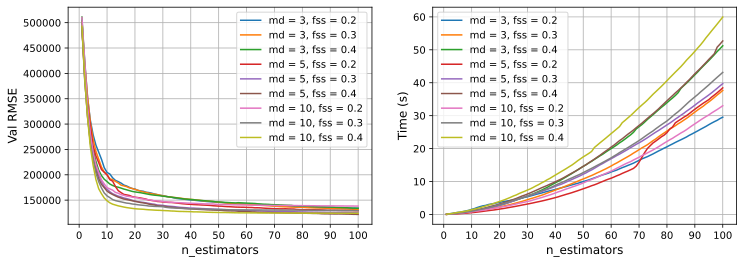

In [ ]:
plot_mul_params(gb_mul_params, gb_mul_hist)
plt.savefig(save_path + 'Plots/'+ 'mul_gb.pdf', bbox_inches='tight')
plt.show()

In [ ]:
save_path = 'drive/MyDrive/Ensembles/ExperimentResults/'

In [ ]:
import pickle as pkl

In [ ]:
# with open(save_path + 'grad_boost_hist_dict', 'rb') as pkl_file:
#     gb_mul_params, gb_mul_hist = pkl.load(pkl_file).values()

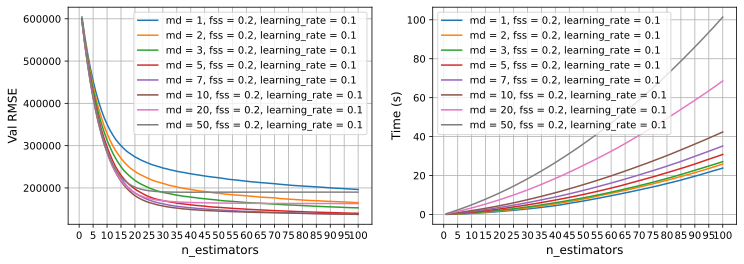

In [ ]:
gb_idxs = [i for i, params in enumerate(gb_mul_params) if params['feature_subsample_size'] == 0.2 and params['learning_rate'] == 0.1]
plot_mul_params([gb_mul_params[i] for i in gb_idxs], [gb_mul_hist[i] for i in gb_idxs])

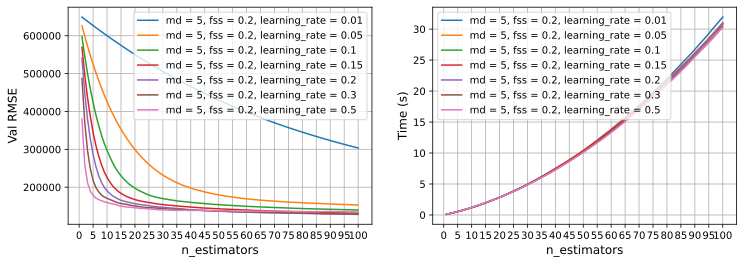

In [ ]:
gb_idxs = [i for i, params in enumerate(gb_mul_params) if params['feature_subsample_size'] == 0.2 and params['max_depth'] == 5]
plot_mul_params([gb_mul_params[i] for i in gb_idxs], [gb_mul_hist[i] for i in gb_idxs])

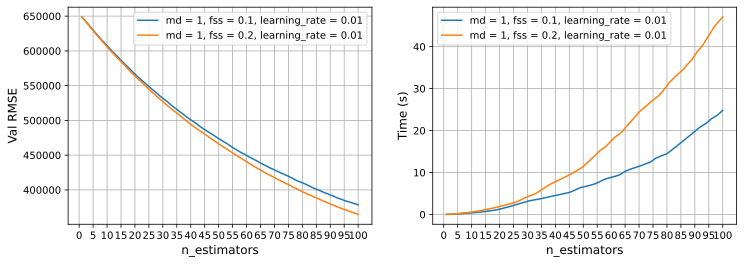

In [ ]:
gb_idxs = [i for i, params in enumerate(gb_mul_params) if params['learning_rate'] == 0.01 and params['max_depth'] == 1]
plot_mul_params([gb_mul_params[i] for i in gb_idxs], [gb_mul_hist[i] for i in gb_idxs])